# **Práctica 4**: Regresión polinomial
## Especificaciones:
El *dataset* a utilizar en esta práctica es el de cal_housing.csv
- Las columnas *longitude, latitude, housingMedianAge, totalRooms, totalBedrooms, population, households, medianIncome* son las características de las casas.
- La columna *medianHouseValue* es el valor a predecir.

Con el dataset especificado realice lo siguiente:

- Cargue el dataset
- Genere un conjunto de entrenamiento con 80% de los datos y 20% para las pruebas
- Mezcle los datos con semilla 0
- Con el conjunto de entrenamiento, genere un conjunto de validación de 10 pliegues


In [1]:
import pandas as pd
import numpy as np
import operator
import os

import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures

In [2]:
class validation_set:
  def __init__(self, X_train, y_train, X_test, y_test):
    self.X_train = X_train
    self.y_train = y_train
    self.X_test = X_test
    self.y_test = y_test

In [3]:
class test_set:
  def __init__(self, X_test, y_test):
    self.X_test = X_test
    self.y_test = y_test

In [4]:
class data_set:
  def __init__(self, validation_set, test_set):
    self.validation_set = validation_set
    self.test_set = test_set

In [5]:
def pliegues_validacion(pliegues, folder):
  # url = 'https://firebasestorage.googleapis.com/v0/b/portafoliowebsite.appspot.com/o/Notas%20Amatsu%2Fcal_housing.csv?alt=media&token=476a6d9d-ca90-42ba-9ab6-1dbfd9babdea'
  url = './dataset/cal_housing.csv'
  df = pd.read_csv(url, sep=',', engine='python')

  # corpus
  X = df[df.columns[0:8].values]
  # target
  y = df['medianHouseValue']
    
  #Separa corpus en conjunto de entrenamiento y prueba
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = True, random_state=0)

  validation_sets = []

  # Número de pliegues
  kf = KFold(n_splits=pliegues)
  c = 0

  for train_index, test_index in kf.split(X_train):
    c = c + 1
    i = 1
    X_train_v, X_test_v = X_train.iloc[train_index], X_train.iloc[test_index]
    y_train_v, y_test_v = y_train.iloc[train_index], y_train.iloc[test_index]
    
    #Agrega el pliegue creado a la lista
    validation_sets.append(validation_set(X_train_v, y_train_v, X_test_v, y_test_v))

    #Almacena el conjunto de prueba
    my_test_set = test_set(X_test, y_test)	
      
    #Guarda el dataset con los pliegues del conjunto de validación y el conjunto de pruebas
    my_data_set = data_set(validation_sets, my_test_set)

    my_data_set.test_set.X_test.to_csv(folder + 'data_test.csv', index = False)
    my_data_set.test_set.y_test.to_csv(folder + 'target_test.csv', index = False)

    cad_pliegues = str(pliegues) + '_'

    for val_set in my_data_set.validation_set:
      cad_i = str(i)
      val_set.X_train.to_csv(folder + 'data_validation_train_'+ cad_pliegues + cad_i + '.csv', index = False)
      val_set.y_train.to_csv(folder + 'target_validation_train_'+ cad_pliegues + cad_i+ '.csv', index = False)
      val_set.X_test.to_csv(folder + 'data_test_'+ cad_pliegues + cad_i+ '.csv', index = False)
      val_set.y_test.to_csv(folder + 'target_test_'+ cad_pliegues + cad_i + '.csv', index = False)
      i = i + 1
  print('Terminado los 10 pliegues')

In [6]:
k = 10
path = 'pliegues/'
# pliegues_validacion(k, path)

Usando el conjunto de entrenamiento realice lo siguiente con cada pliegue:

1. Utilice **regresión lineal mediante gradiente descendiente estocástico** para generar una línea que se ajuste lo mejor posible a los datos (modificando parámetros *max_iter, learning_rate y eta0*) y reporte el error cuadrado medio (MSE) y el coeficiente de determinación ($r^2$)


In [7]:
name_files = os.listdir('pliegues/')

In [8]:
data_train = list(filter(lambda x: x.startswith('data_validation_train'), name_files))
target_train = list(filter(lambda x: x.startswith('target_validation_train'), name_files))
print(len(data_train), len(target_train))

10 10


In [9]:
mse_list = []
r2_list = []

In [24]:
def sgdregressor (grade, x, y, learning, eta = 0.01, color = 'g', max = int(), i = int(), robusto = False, estandar = False):
  """
  grade : grado de la regresión polinomial
  x : datos de x
  y : datos de y
  learning : metodo de aprendizaje del SDGRegresor (constant, optimal, invscaling, adaptive)
  eta : valor de eta0 (defecto 0.01)
  max : número maximo de iteraciones
  color : posición de un vector con nombres de colores
  i : número de iteración
  robusto : valor boleano para ver si se escalan o no los datos
  estandar : valor booleano para ver si se escalan o no los datos
  """

  polynomial_features= PolynomialFeatures(degree=grade)
  x_poly = polynomial_features.fit_transform(x)
  escalado = 'No'

  if robusto:
    x_poly = preprocessing.RobustScaler().fit_transform(x_poly)
    escalado = 'Robusto'

    
  
  if estandar:
    x_poly = preprocessing.StandardScaler().fit_transform(x_poly)
    escalado = 'Estandar'
   
   
  regr = SGDRegressor(learning_rate = learning, eta0 = eta, max_iter= max)
  regr.fit(x_poly, y.values.ravel())
  y_poly_pred = regr.predict(x_poly)
  mse = mean_squared_error(y, y_poly_pred)
  r2 = r2_score(y, y_poly_pred)

  mse_list.append(mse)
  r2_list.append(r2)


  # ~ #Ajustes para que la curva trazada se vea correctamente
  sort_axis = operator.itemgetter(0)
  sorted_zip = sorted(zip(x,y_poly_pred), key=sort_axis)

  # print (tuple(sorted_zip))
  x_sorted, y_poly_pred = zip(*sorted_zip)
  print(pd.DataFrame({'x': np.reshape(x_sorted,(1,-1))[0], 'Predicted': y_poly_pred}))

  # plt.plot(x_sorted, y_poly_pred, color='b')
  plt.title('Gradiente estocástico, grado:', grade,  ', escalado: '+ escalado)
  plt.plot(x_sorted,y_poly_pred, color = color, label='pliegue'+str(i+1))
  plt.legend()
  print ('Regresión polinomial estocástico grado {}\nmse: {} r2: {}'.format(grade, mse, r2))
  # return [np.mean(np.array(mse_list)), np.mean(np.array(r2_list))]

In [25]:
def itera(grado, val_ap, val_e, val_itera, robusto = False, normal = False):

  # mse_list = []
  # r2_list = []
  colores = ['red', 'gray', 'green', 'black', 'orange', 'teal', 'yellow', 'coral', 'palegreen', 'aqua', 'cyan']

  for i, file in enumerate(data_train):

    print('Grado '+ str(grado) + ' k='+str(i))

    x = pd.read_csv(path + file)
    y = pd.read_csv(path + 'target_validation_train_10_'+ file[25:-4] + '.csv')

    # if tipo == 0:
    #   generate_polynomial(grado, x, y,'optimal',0.001, colores[i], i)
    # elif tipo == 1:
    sgdregressor(1,x, y, val_ap, val_e, colores[i], val_itera, i, robusto= robusto, estandar = normal)

2. Utilice **regresión polinomial mediante el gradiente descendiente estocástico** con poinomios de grado **2 y 3** para generar una línea curva que se ajuste lo mejor posible a los datos (modificando parámetros *max_iter, learning_rate y eta0*), y reporte MSE y $r^2$.

3. Almacene los valores MSE y $r^2$ de cada pliegue y al terminar los 10 pliegues reporte el resultado de estos.

Regresion Lineal (grado 3), con metodo constant, escalado normal
Grado 3 k=0
                  x      Predicted
0        households  353166.778257
1  housingMedianAge  216679.639173
2          latitude  360954.835221
3         longitude  314944.260195
4      medianIncome  326355.162874
5        population  266814.539411
6     totalBedrooms  267021.967647
7        totalRooms   63061.846220
Regresión polinomial estocástico grado 1
mse: 4794972538.417473 r2: 0.6402336202918374
Grado 3 k=1
                  x      Predicted
0        households  247233.646329
1  housingMedianAge  215276.379125
2          latitude  280788.773410
3         longitude  175388.882280
4      medianIncome  462667.695303
5        population  439960.427605
6     totalBedrooms  244914.110782
7        totalRooms  124489.479165
Regresión polinomial estocástico grado 1
mse: 4875901804.657674 r2: 0.6359514493880687
Grado 3 k=2
                  x      Predicted
0        households  246965.394208
1  housingMedianAge  2151

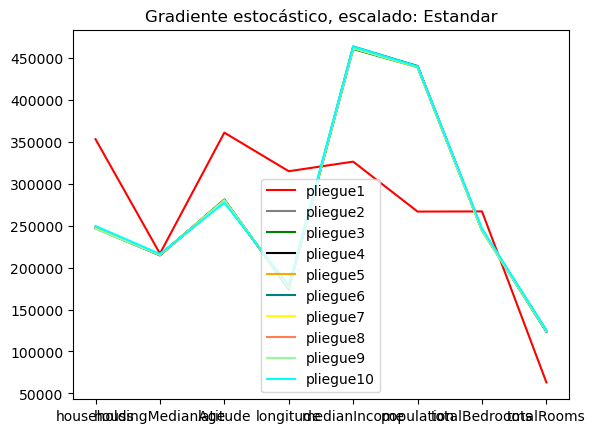

In [21]:
# print('Regresión lineal (de grado 1), sin escalado')
# itera(1, 'constant', 0.00000000001, 1000000000)
# print('Regresión lineal (de grado 1), escalado : robusto')
# itera(1, 'constant', 0.00001, 1000000000, True)
# print('Regresión lineal (de grado 1), escalado : Normal')
# itera(1, 'constant', 0.00001, 10000000, normal=True)


# print('Regresión lineal (de grado 2), con metodo constant,sin escalado')
# itera(2, 'constant', 0.0000000001, 1000000)
# print('Regresión lineal (de grado 2), con metodo constant, escalado robusto')
# itera(2, 'constant', 0.00001, 1000000000, robusto=True)
# print('Regresión lineal (de grado 2), con metodo constant, escalado normal')
# itera(2, 'constant', 0.00001, 1000000000, normal=True)


# print('Regresión lineal (de grado 3), con metodo constant, sin escalado')
# itera(3, 'constant', 0.0000000001, 1000000000)
# print('Regresión lineal (de grado 3), con metodo constant, escalado robusto')
# itera(3, 'constant', 0.00001, 1000000000, robusto=True)
# print('Regresion Lineal (grado 3), con metodo constant, escalado normal')
# itera(3, 'constant', 0.000001, 1000000000, normal=True)

Con aprendizaje optimal no mejora

Regresión lineal (de grado 3), con metodo optimal, escalado normal
Grado 3 k=0
                  x      Predicted
0        households  341320.840075
1  housingMedianAge  199711.925392
2          latitude  352188.841207
3         longitude  346275.114922
4      medianIncome  309733.427339
5        population  267095.798829
6     totalBedrooms  287894.951788
7        totalRooms   52311.144777
Regresión polinomial estocástico grado 1
mse: 5069821018.075465 r2: 0.619611762355716
Grado 3 k=1
                  x      Predicted
0        households  277699.474323
1  housingMedianAge  236038.862545
2          latitude  286846.281051
3         longitude  217635.585693
4      medianIncome  417835.634543
5        population  465936.532310
6     totalBedrooms  255387.055336
7        totalRooms  153369.847695
Regresión polinomial estocástico grado 1
mse: 5829079206.798388 r2: 0.5647845420902431
Grado 3 k=2
                  x      Predicted
0        households  201205.639720
1  housingMedianAge  203

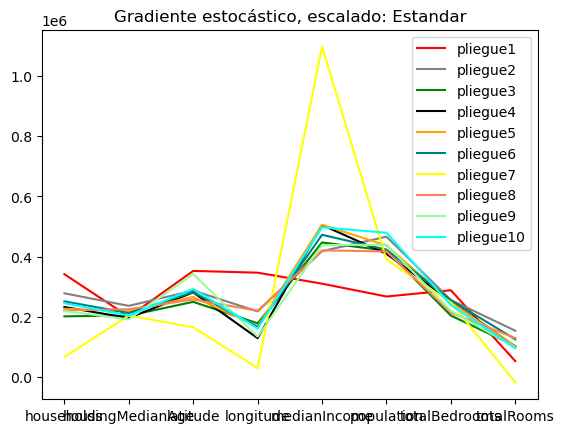

In [90]:
# print('Regresión lineal (de grado 1), con metodo optimal, sin escalado')
# itera(1, 'optimal', 0.0000000000000000001, 1000000000)

# print('Regresión lineal (de grado 1), con metodo optimal, escalado robusto')
# itera(1, 'optimal', 0.00000000000000001, 1000000000, robusto= True)

# print('Regresión lineal (de grado 1), con metodo optimal, escalado normal')
# itera(1, 'optimal', 0.000001, 1000000000, normal=True)

# print('Regresión lineal (de grado 2), con metodo optimal, sin escalado')
# itera(2, 'optimal', 0.0000000000000000001, 1000000000)

# print('Regresión lineal (de grado 2), con metodo optimal, escalado robusto')
# itera(2, 'optimal', 0.00000000000000001, 1000000000, robusto= True)

# print('Regresión lineal (de grado 2), con metodo optimal, escalado normal')
# itera(2, 'optimal', 0.000001, 1000000000, normal=True)

# print('Regresión lineal (de grado 3), con metodo optimal, sin escalado')
# itera(3, 'optimal', 0.0000000000001, 1000000000)

# print('Regresión lineal (de grado 3), con metodo optimal, escalado robusto')
# itera(3, 'optimal', 0.000000000000001, 1000000000, robusto= True)

# print('Regresión lineal (de grado 3), con metodo optimal, escalado normal')
# itera(3, 'optimal', 0.000001, 1000000000, normal=True)

Regresión lineal (de grado 1), con metodo invscaling, sin escalado
Grado 1 k=0
                  x      Predicted
0        households  272803.453166
1  housingMedianAge  215808.095619
2          latitude  216286.692602
3         longitude  210555.997893
4      medianIncome  325130.484179
5        population  210115.082382
6     totalBedrooms  216949.648608
7        totalRooms  175187.698577
Regresión polinomial estocástico grado 1
mse: 11666883845.428371 r2: 0.12463470230202789
Grado 1 k=1
                  x      Predicted
0        households  194907.612797
1  housingMedianAge  175679.789323
2          latitude  190760.588395
3         longitude  156940.424455
4      medianIncome  336946.024871
5        population  219718.663188
6     totalBedrooms  207703.564914
7        totalRooms  154410.787501
Regresión polinomial estocástico grado 1
mse: 12100780908.407652 r2: 0.09652164307939348
Grado 1 k=2
                  x      Predicted
0        households  204437.906432
1  housingMedianAge

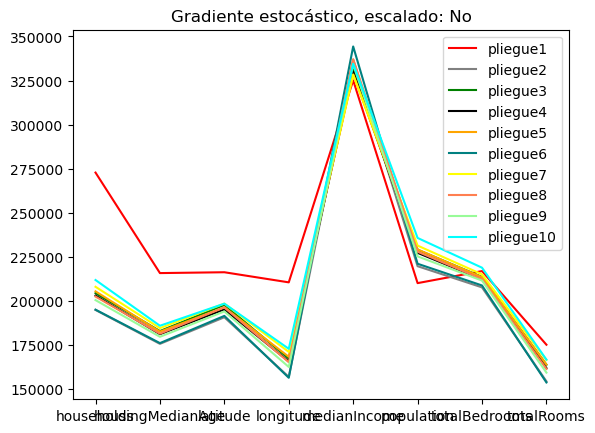

In [21]:
print('Regresión lineal (de grado 1), con metodo invscaling, sin escalado')
itera(1, 'invscaling', 0.000000001, 1000000000)

# print('Regresión lineal (de grado 1), con metodo optimal, escalado robusto')
# itera(1, 'invscaling', 0.00000001, 1000000000, robusto= True)

# print('Regresión lineal (de grado 1), con metodo optimal, escalado normal')
# itera(1, 'invscaling', 0.000001, 1000000000, normal=True)

# print('Regresión lineal (de grado 2), con metodo optimal, sin escalado')
# itera(2, 'invscaling', 0.00000001, 1000000000)

# print('Regresión lineal (de grado 2), con metodo optimal, escalado robusto')
# itera(2, 'invscaling', 0.000001, 1000000000, robusto= True)

# print('Regresión lineal (de grado 2), con metodo optimal, escalado normal')
# itera(2, 'invscaling', 0.000001, 1000000000, normal=True)

# print('Regresión lineal (de grado 3), con metodo optimal, sin escalado')
# itera(3, 'invscaling', 0.0000000001, 1000000000)

# print('Regresión lineal (de grado 3), con metodo optimal, escalado robusto')
# itera(3, 'invscaling', 0.0000000001, 1000000000, robusto= True)

# print('Regresión lineal (de grado 3), con metodo optimal, escalado normal')
# itera(3, 'invscaling', 0.000001, 1000000000, normal=True)


Regresión lineal (de grado 3), con metodo optimal, escalado normal
Grado 3 k=0
                  x      Predicted
0        households  353220.246354
1  housingMedianAge  216795.087928
2          latitude  361137.565646
3         longitude  314916.382577
4      medianIncome  326490.397190
5        population  266683.790026
6     totalBedrooms  267079.116093
7        totalRooms   63153.968352


ValueError: ', escalado: estandar' is not a valid value for loc; supported values are 'left', 'center', 'right'

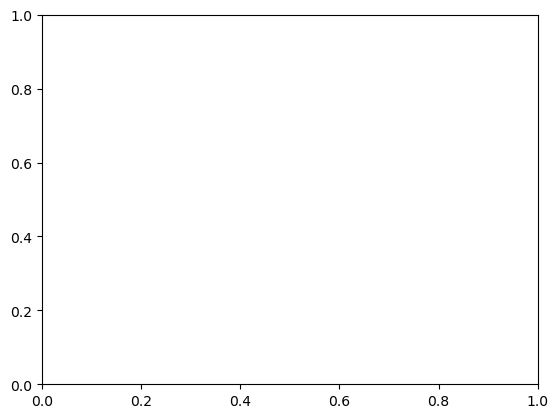

In [26]:
# print('Regresión lineal (de grado 1), con metodo optimal, sin escalado')
# itera(1, 'adaptive', 0.00000001, 1000000000)

# print('Regresión lineal (de grado 1), con metodo optimal, escalado robusto')
# itera(1, 'adaptive', 0.00000001, 1000000000, robusto= True)

# print('Regresión lineal (de grado 1), con metodo optimal, escalado normal')
# itera(1, 'adaptive', 0.000001, 1000000000, normal=True)

# print('Regresión lineal (de grado 2), con metodo optimal, sin escalado')
# itera(2, 'adaptive', 0.00000001, 1000000000)

# print('Regresión lineal (de grado 2), con metodo optimal, escalado robusto')
# itera(2, 'adaptive', 0.000001, 1000000000, robusto= True)

# print('Regresión lineal (de grado 2), con metodo optimal, escalado normal')
# itera(2, 'adaptive', 0.000001, 1000000000, normal=True)

# print('Regresión lineal (de grado 3), con metodo optimal, sin escalado')
# itera(3, 'adaptive', 0.0000000001, 1000000000)

# print('Regresión lineal (de grado 3), con metodo adaptive, escalado robusto')
# itera(3, 'adaptive', 0.00001, 1000000000, robusto= True)

print('Regresión lineal (de grado 3), con metodo optimal, escalado normal')
itera(3, 'adaptive', 0.000001, 1000000000, normal=True)



De todos los médotos de aprendizaje el más óptimo fue "adaptive".

Ahora vamos a empezar con el gradiente estocastico de segundo grado:

In [ ]:
print('Regresión lineal (de grado 0), con metodo optimal, et0 =0.000000000001 y 1000000000 iteraciónes')
# con los mismos valores de antes, pero aprendizaje optimo
itera(2, 'optimal', 0.00000000000000001, 1000000000,)

Usando el conjunto de validación realice lo siguiente para cada pliegue:

1. Usando los datos con escalado estándar realizar los experimentos anteriores.

2. Usando los datos con escalado robusto repita los experimentos anteriores.

Usando el conjunto de entrenamiento entene el modelo usando el tipo de regresión (lineal o polinomial) y el método de escalado (sin escalado, escalado, robusto) que mejor resultado obtuvo en promedio en el conjunto de validación.

Usando el modelo anterior realice la predicción de los datos del conjunto de prueba y reporte el MSE y $r^2$.

Grado 2, i= 0
Regresión polinomial grado 2
mse: 4006049010.4610105 r2: 0.7003219598573915 

Grado 2, i= 1
Regresión polinomial grado 2
mse: 3958476613.5731864 r2: 0.7039928615469844 

Grado 2, i= 2
Regresión polinomial grado 2
mse: 3985463222.3924303 r2: 0.7013843845576638 

Grado 2, i= 3
Regresión polinomial grado 2
mse: 3947694594.082235 r2: 0.7067979141243539 

Grado 2, i= 4
Regresión polinomial grado 2
mse: 3914903765.1412716 r2: 0.7067843243486969 

Grado 2, i= 5
Regresión polinomial grado 2
mse: 4011836992.3323674 r2: 0.7017963426768155 

Grado 2, i= 6
Regresión polinomial grado 2
mse: 4037938421.527735 r2: 0.6985161537885796 

Grado 2, i= 7
Regresión polinomial grado 2
mse: 3984962761.156507 r2: 0.701008584644307 

Grado 2, i= 8
Regresión polinomial grado 2
mse: 3996830890.2678623 r2: 0.7013028943995523 

Grado 2, i= 9
Regresión polinomial grado 2
mse: 4006192115.1862254 r2: 0.7005352675289225 



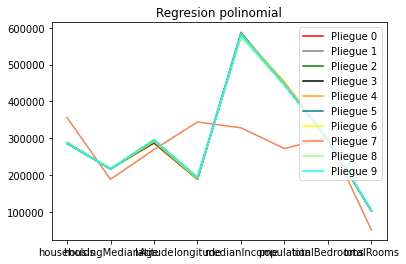

In [ ]:
for i, file in enumerate(data_train):
  print('Grado 2, i=', i)
  x = pd.read_csv(path + file)
  y = pd.read_csv(path + 'target_validation_train_10_'+ file[25:-4] + '.csv')